# **Efficient Checkpointing on LeNet** 

Let's compare these 3 approaches : 
1. **Initial accuracy measurement:** Train LeNet on MNIST and achieve a baseline accuracy of around 99.9% without considering poisoned models.
2. **Incremental learning:** Implement incremental learning on the divided MNIST subsets and measure the accuracy drop due to this method.
3. **LC-checkpoint and Delta LoRA:** Apply LC-checkpoint and Delta LoRA on top of incremental learning and observe the resulting accuracy.

---

## **Importing Libraries**

In [4]:
import glob
import sys
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.LeNet import LeNet
import src.compression.deltaCompress as lc_compress
from src.models.LeNet_LowRank import getBase, LeNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression

## **Connexion to wandb**

In [5]:
import wandb
# Connect to W&B
wandb.login(key="beb938fdf67db528128a4298e19b9997afd83dfd")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Bradf\.netrc


True

## **Variables and Constants**

In [6]:
train_batch_size = 64
test_batch_size = 1000
num_work = 14

## **Load MNIST dataset**

In [7]:
def data_loader():

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(0.1307, 0.3081)
    ])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)

    trainset.data = trainset.data.clone()[:]
    trainset.targets = trainset.targets.clone()[:]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size,
                                              shuffle=True, num_workers=num_work)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    testset.data = testset.data.clone()[:]
    testset.targets = testset.targets.clone()[:]
    testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size,
                                             shuffle=False, num_workers=num_work)
    
    return trainloader, testloader

In [8]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

### **Bypass the matplotlib error**

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### **Verify if data loaded correctly**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

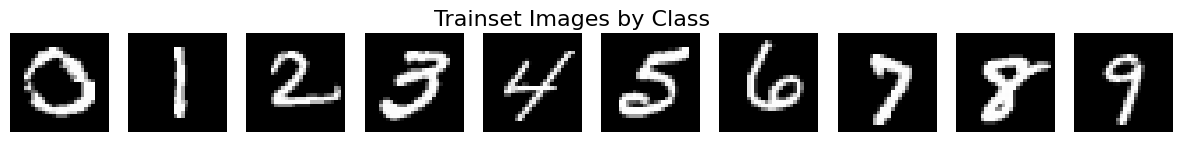

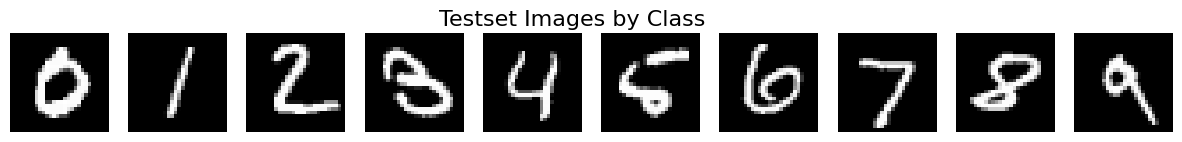

In [6]:
# Going through the dataloader to extract an image per class
def get_images_by_class(dataloader):
    images_by_class = {i: None for i in range(10)}
    for images, labels in dataloader:
        for i in range(len(labels)):
            label = labels[i].item()
            if images_by_class[label] is None:
                images_by_class[label] = images[i]
            if all(v is not None for v in images_by_class.values()):
                return images_by_class
    return images_by_class

def plot_images(images_by_class, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images_by_class[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()


train_images = get_images_by_class(train_loader)
test_images = get_images_by_class(test_loader)

plot_images(train_images, "Trainset Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

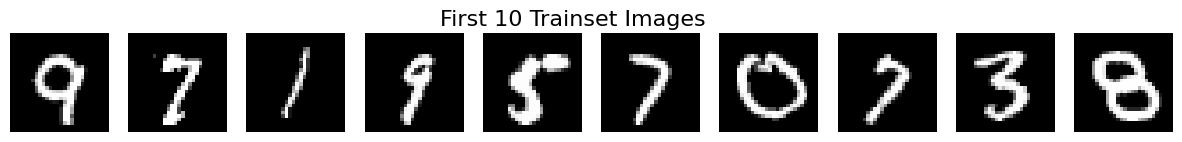

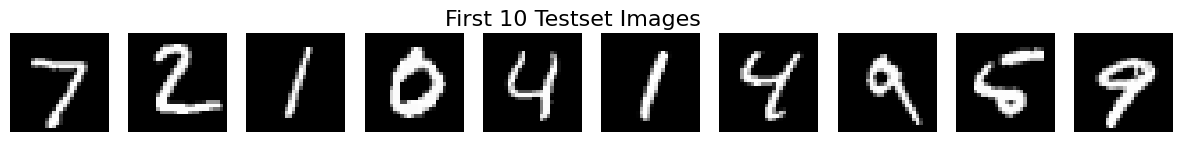

In [7]:
def plot_first_images(dataloader, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    
    images_shown = 0
    for images, labels in dataloader:
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            ax = axes[images_shown]
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.show()

plot_first_images(train_loader, "First 10 Trainset Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Splitting the dataset into three subsets having each all classes**

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def stratified_split(dataset, proportions):
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(10)]
    
    split_indices = []
    for proportion in proportions:
        class_split_indices = [np.split(indices, [int(proportion[0]*len(indices)), int((proportion[0]+proportion[1])*len(indices)), int((proportion[0]+proportion[1]+proportion[2])*len(indices))]) for indices in class_indices]
        split_indices.append([np.concatenate([split[i] for split in class_split_indices]) for i in range(4)])
    
    return split_indices

def data_loader():
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the whole MNIST dataset
    full_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
    # Proportions pour les splits
    proportions = [(0.25, 0.25, 0.25, 0.25)] * 10
    
    # Obtenir les indices pour chaque split
    split_indices = stratified_split(full_trainset, proportions)
    
    # Créer des Subsets
    trainset1 = Subset(full_trainset, split_indices[0][0])
    trainset2 = Subset(full_trainset, split_indices[0][1])
    trainset3 = Subset(full_trainset, split_indices[0][2])
    trainset4 = Subset(full_trainset, split_indices[0][3])

    # Créer des DataLoaders pour chacun des sous-ensembles
    train_loader1 = DataLoader(trainset1, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader2 = DataLoader(trainset2, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader3 = DataLoader(trainset3, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader4 = DataLoader(trainset4, batch_size=train_batch_size, shuffle=True, num_workers=2)

    # Charger le jeu de données de test complet
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

    return train_loader1, train_loader2, train_loader3, train_loader4, test_loader

# Load DataLoaders
train_loader1, train_loader2, train_loader3, train_loader4, test_loader = data_loader()

# Vérification des tailles des DataLoaders
print(f'Size of train_loader1: {len(train_loader1.dataset)}')
print(f'Size of train_loader2: {len(train_loader2.dataset)}')
print(f'Size of train_loader3: {len(train_loader3.dataset)}')
print(f'Size of train_loader4: {len(train_loader4.dataset)}')
print(f'Size of train_loader: {len(train_loader1.dataset) + len(train_loader2.dataset) + len(train_loader3.dataset) + len(train_loader4.dataset)}')
print(f'Size of test_loader: {len(test_loader.dataset)}')


Size of train_loader1: 14995
Size of train_loader2: 15002
Size of train_loader3: 14998
Size of train_loader4: 15005
Size of train_loader: 60000
Size of test_loader: 10000


### **Verify the content of train_loader subset**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

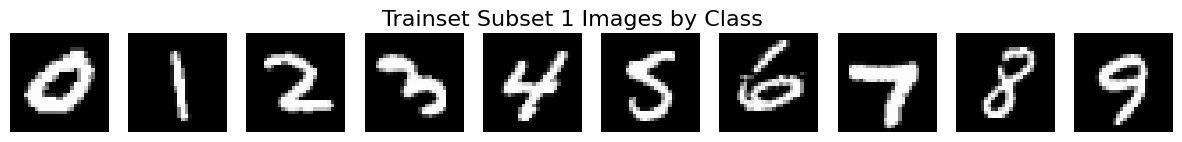

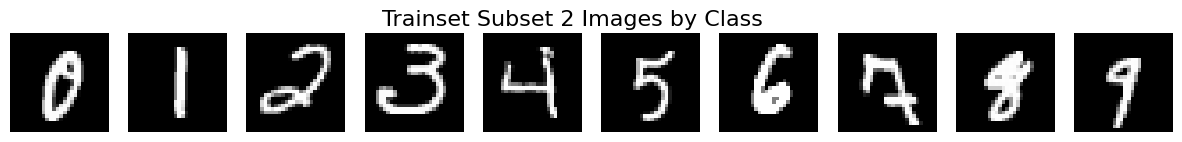

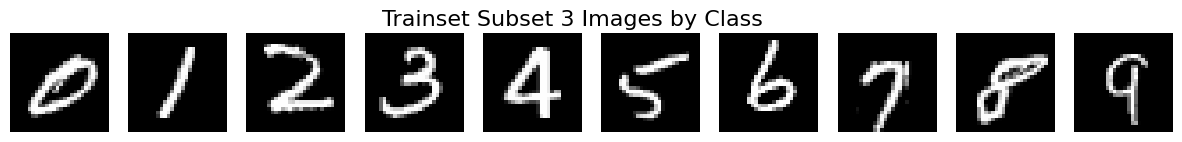

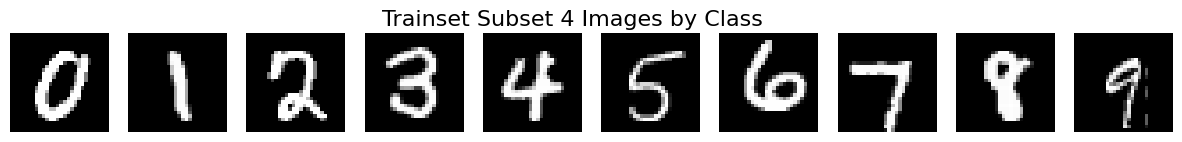

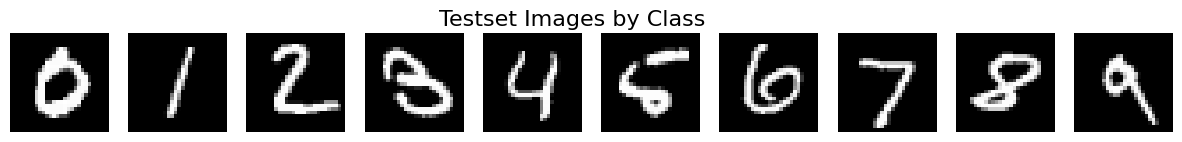

In [23]:
# Going through the dataloader to extract an image per class

train_images1 = get_images_by_class(train_loader1)
train_images2 = get_images_by_class(train_loader2)
train_images3 = get_images_by_class(train_loader3)
train_images4 = get_images_by_class(train_loader4)
test_images = get_images_by_class(test_loader)

plot_images(train_images1, "Trainset Subset 1 Images by Class")
plot_images(train_images2, "Trainset Subset 2 Images by Class")
plot_images(train_images3, "Trainset Subset 3 Images by Class")
plot_images(train_images4, "Trainset Subset 4 Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

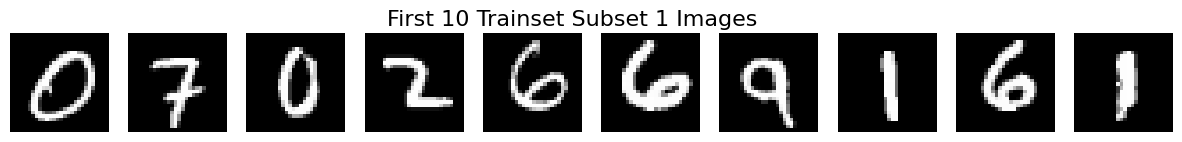

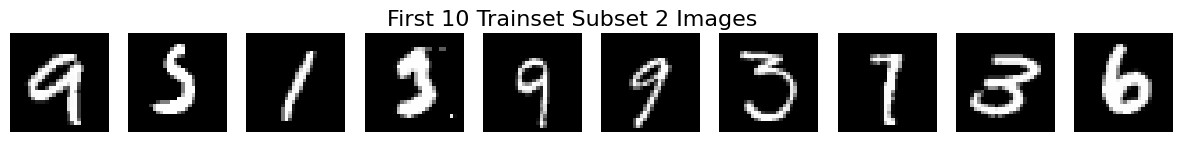

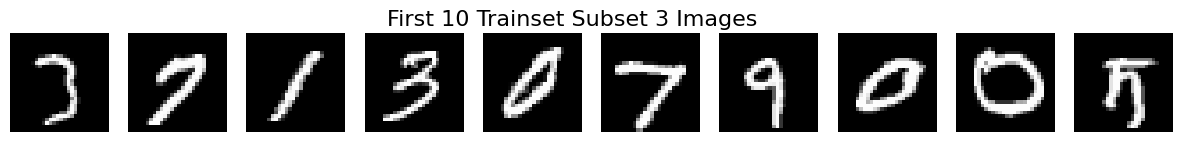

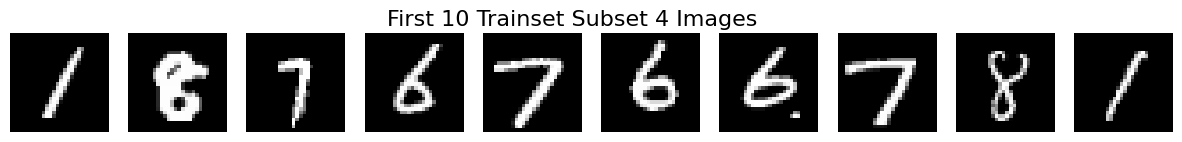

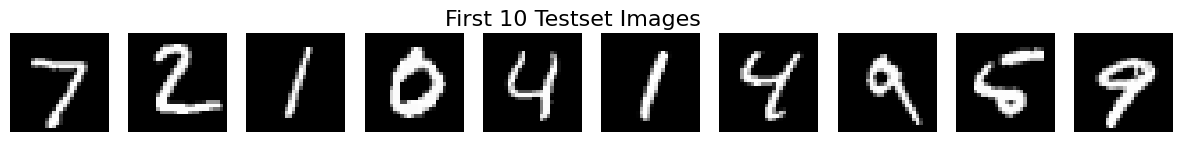

In [24]:
plot_first_images(train_loader1, "First 10 Trainset Subset 1 Images")
plot_first_images(train_loader2, "First 10 Trainset Subset 2 Images")
plot_first_images(train_loader3, "First 10 Trainset Subset 3 Images")
plot_first_images(train_loader4, "First 10 Trainset Subset 4 Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Defining some variables and creating files & folders**

In [11]:
HDFP = "./volumes/Ultra Touch" # Load HHD

SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

SAVE_BRANCH_PRETRAINING = HDFP + "/lobranch-snapshot/branchpoints/lenet/pretraining"
if not os.path.exists(SAVE_BRANCH_PRETRAINING):
    os.makedirs(SAVE_BRANCH_PRETRAINING)

SAVE_BRANCH = HDFP + "/lobranch-snapshot/branchpoints/lenet/branch"
if not os.path.exists(SAVE_BRANCH):
    os.makedirs(SAVE_BRANCH)

### **Pretraining the model**

In [14]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.005
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Pretraining-Without-Incremental-Learning", 
           tags=["LeNet", "Pretraining", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "MNIST train dataset[:]",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )

print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.70:
        torch.save(model_for_checkpoint.state_dict(), SAVE_BRANCH_PRETRAINING + "/branch_{:.3f}.pt".format(valid_accuracy))
        print("Model saved with accuracy: {:.3f} in the file: branch_{:.3f}.pt".format(valid_accuracy, valid_accuracy))
        # Comment the line below if you want to train on the whole dataset
        isLoop = False

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

Let's use 1 GPU!


Start of model training...
Epoch: [0/49], Training Loss: 1.891492, Validation Loss: 1.149016, Training Accuracy: 0.558367, Validation Accuracy: 0.745900
End of model training...


train_accuracy,▁
train_loss,▁
valid_accuracy,▁
valid_loss,▁
train_accuracy,0.55837
train_loss,1.89149
valid_accuracy,0.7459
valid_loss,1.14902


---

## **First version : LeNet without Incremental Learning**

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.02
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Without-Incremental-Learning", 
           tags=["LeNet", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "MNIST train dataset[:]",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )

print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

---

## **Second version : LeNet with Incremental Learning**

##### **Training on trainloader1**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning = nn.DataParallel(model_with_incremental_learning)
    model_with_incremental_learning.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning.to(device)

# Training code
NUM_EPOCHES = 45
learning_rate = 0.01
isLoop = True
optimizer = torch.optim.SGD(model_with_incremental_learning.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning", 
           tags=["LeNet", "With-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataloader1",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )



print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader1):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader1...")

##### **Training on trainloader2**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader2...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader2):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

##### **Training on trainloader3**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader3...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader3):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader3.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader3...")
# Finish the wandb run
wandb.finish()

---

## **Third version : LeNet with Incremental Learning, LC-checkpoint, and Delta-LoRA**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning_lc_dlora = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning_lc_dlora = nn.DataParallel(model_with_incremental_learning_lc_dlora)
    model_with_incremental_learning_lc_dlora.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning_lc_dlora.to(device)

# Training code
NUM_EPOCHES = 30
learning_rate = 0.1
learning_rate_dloralc = 0.1
learning_rate1 = 0.005
# super_step = len(train_loader2)
# super_step = 20
isLoop = True

optimizer = torch.optim.SGD(model_with_incremental_learning_lc_dlora.parameters(), lr=learning_rate1)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning_LC_DLORA-Without-Restore_25_25_25_25", 
           tags=["LeNet", "With-Incremental-Learning_LC_DLORA", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "splitting": "25-25-25-25",
                    "train dataset 1": "MNIST train dataloader1",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate_nothing": learning_rate,
                    "learning_rate_dloralc": learning_rate_dloralc,
                    "optimizer": "SGD"
                }
           )

print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning_lc_dlora.train()
        for iter, data in enumerate(train_loader1):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning_lc_dlora(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning_lc_dlora.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning_lc_dlora(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.7:
        rounded_valid_acc = round(valid_accuracy, 4)
        # torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vit/branch_{}.pt".format(rounded_valid_acc))
        torch.save(model_with_incremental_learning_lc_dlora.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
        print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))
        isLoop = False
        break
    # if valid_accuracy > 0.90:
    #     isLoop = False
    #     break

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss,
        "valid_loss_lc": valid_loss,
        "train_accuracy_lc": train_accuarcy,
        "valid_accuracy_lc": valid_accuracy, 
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch,
    })
    # wandb.log({
    #     "train_loss_dloralc": train_loss,
    #     "valid_loss_dloralc": valid_loss,
    #     "train_accuracy_dloralc": train_accuarcy,
    #     "valid_accuracy_dloralc": valid_accuracy,
    #     "train_loss_lc": train_loss,
    #     "valid_loss_lc": valid_loss,
    #     "train_accuracy_lc": train_accuarcy,
    #     "valid_accuracy_lc": valid_accuracy, 
    #     "train_loss": train_loss,
    #     "valid_loss": valid_loss,
    #     "train_accuracy": train_accuarcy,
    #     "valid_accuracy": valid_accuracy,
    #     "valid_loss_dloralc_restored": valid_loss,
    #     "valid_accuracy_dloralc_restored": valid_accuracy,
    #     "epoch": epoch,
    # })

print("End of model training on dataloader1...")

Let's use 1 GPU!


Start of model training on dataloader1...
Epoch: [0/29], Training Loss: 2.263898, Validation Loss: 2.211693, Training Accuracy: 0.247016, Validation Accuracy: 0.452200
Epoch: [1/29], Training Loss: 2.111947, Validation Loss: 1.965460, Training Accuracy: 0.541380, Validation Accuracy: 0.571200
Epoch: [2/29], Training Loss: 1.775779, Validation Loss: 1.560456, Training Accuracy: 0.561387, Validation Accuracy: 0.603400
Model saved at accuracy: 0.7024
End of model training on dataloader1...


### **Working on training with delta-LoRA and LC-checkpoint** 

In [12]:
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.3.weight"]
RANK = -1
SCALING = -1
BRANCH_ACC = "0.746"
learning_rate = 0.02
learning_rate_dloralc = 0.1
NUM_EPOCHES = 2

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
original = LeNet().to(device)
model_original = LeNet().to(device)
model_no_touch = LeNet().to(device)

In [15]:
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/lenet/pretraining/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))
model_no_touch.load_state_dict(torch.load(BRANCH_LOC))

<All keys matched successfully>

In [16]:
w, b = getBase(original)
model = LeNet_LowRank(w, b, rank = RANK).to(device)

In [17]:
print(model.state_dict().keys())

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])


In [18]:
load_sd_decomp(torch.load(BRANCH_LOC, map_location=device), model, DECOMPOSED_LAYERS)

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)
optimizer_lc_only = torch.optim.SGD(model_original.parameters(), lr=learning_rate)
optimizer_no_touch = torch.optim.SGD(model_no_touch.parameters(), lr=learning_rate)

In [20]:
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

In [21]:
train_loader_list = [train_loader1, train_loader2, train_loader3, train_loader4]

for j in range(len(train_loader_list)):
    train_loader_txt = "train_loader{}".format(j+1)
    print("--------------------------")
    print("Beginning of model training on {}...".format(train_loader_txt))

    full_accuracy_dloralc = 0
    decomposed_full_accuracy_dloralc = 0
    restored_accuracy_dloralc = 0
    lc_accuracy_dloralc = 0

    for epch in range(NUM_EPOCHES):
        for i, data in enumerate(train_loader_list[j], 0):

            SAVE_LOC_j = SAVE_LOC + "/"+train_loader_txt
            if not os.path.exists(SAVE_LOC_j):
                os.makedirs(SAVE_LOC_j)
                
            SAVE_LOC_OLC_j = SAVE_LOC_OLC + "/"+train_loader_txt
            if not os.path.exists(SAVE_LOC_OLC_j):
                os.makedirs(SAVE_LOC_OLC_j)
            print("Epoch: {}, Iteration: {}".format(epch, i))
            
            set_path = "/set_{}".format(current_set)
            if not os.path.exists(SAVE_LOC_j + set_path):
                os.makedirs(SAVE_LOC_j + set_path)

            if i == 0 and epch == 0: # first iteration, create baseline model
                base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC_j + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)
            else:
                if i % 10 == 0: 
                    # full snapshot!
                    new_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                    original = new_model # Changing previous "original model" used to restore the loRA model.
                    
                    current_set += 1
                    current_iter = 0

                    set_path = "/set_{}".format(current_set)
                    if not os.path.exists(SAVE_LOC_j + set_path):
                        os.makedirs(SAVE_LOC_j + set_path)
                    
                    # Rebuilding LoRA layers => reset model!
                    w, b = getBase(original)
                    model = LeNet_LowRank(w, b, rank = RANK).to(device)
                    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                    load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                    base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC_j + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                else:
                    # Delta-compression
                    delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                    base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                    compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                                decomp_delta)
                    
                    # Saving checkpoint
                    lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC_j + 
                                    "/set_{}".format(current_set))
        
                    base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                    base_decomp = np.add(full_dcomp_delta, base_decomp)

                    current_iter += 1
                
            # ==========================
            # Saving using LC-Checkpoint
            # ==========================
                    
            if i == 0 and epch == 0:
                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC_j + set_path):
                    os.makedirs(SAVE_LOC_OLC_j + set_path)
                torch.save(cstate, SAVE_LOC_OLC_j + set_path + "/initial_model.pt")
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC_j + set_path, DECOMPOSED_LAYERS)
            else:
                if i % 10 == 0:
                    cstate = model_original.state_dict()
                    current_set_old_lc += 1
                    current_iter_old_lc = 0
                    set_path = "/set_{}".format(current_set_old_lc)
                    if not os.path.exists(SAVE_LOC_OLC_j + set_path):
                        os.makedirs(SAVE_LOC_OLC_j + set_path)
                    torch.save(cstate, SAVE_LOC_OLC_j + set_path + "/initial_model.pt")
                    prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC_j + set_path, DECOMPOSED_LAYERS)
                else:
                    cstate = model_original.state_dict()
                    old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                    olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                    olc.save_checkpoint(SAVE_LOC_OLC_j + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                        old_lc_bias, current_iter_old_lc)
                    prev_state = np.add(prev_state, update_prev)
                    current_iter_old_lc += 1
            
            # ==========================
            # Training on Low-Rank Model
            # ==========================

            # Get the inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs,labels)
            loss.backward()
            print("LoRA+LC Training Loss (Decomposed): {}".format(loss.item()))
            optimizer.step()
                
            # ======================
            # Training on Full Model
            # ======================

            # Zero the parameter gradients
            optimizer_lc_only.zero_grad()

            # Forward + backward + optimize
            outputs_full = model_original(inputs)
            loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
            loss_full.backward()
            print("LC Training Loss (Full): {}".format(loss_full.item()))
            optimizer_lc_only.step()

            if i % 20 == 0:
                print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                            acc(outputs_full, labels)))

            if i != 0  and i % 5 == 0: # Evaluation on testing set
                full_accuracy_dloralc = evaluate_accuracy_gpu(model_original, test_loader, device)
                full_accuracy.append(full_accuracy_dloralc)

                decomposed_full_accuracy_dloralc = evaluate_accuracy_gpu(model, test_loader, device)
                decomposed_full_accuracy.append(decomposed_full_accuracy_dloralc)
                
                restored_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, 
                                            rank = RANK, scaling = SCALING)
                restored_accuracy_dloralc_restored = evaluate_accuracy(restored_model, test_loader)
                restored_accuracy.append(restored_accuracy_dloralc_restored)

                restored_lc_model = LeNet().to(device)
                restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                    restored_model.state_dict(), DECOMPOSED_LAYERS))
                lc_accuracy_lc = evaluate_accuracy_gpu(restored_lc_model, test_loader, device)
                lc_accuracy.append(lc_accuracy_lc)
                print("Full accuracy (w/o dLoRA+LC): {}, LC accuracy: {}, Decomposed-Full (w/dLoRA+LC) accuracy: {}, Decomposed-Restored (w/dLoRA+LC restored) accuracy: {}".format(
                    full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))
                
                wandb.log({
                    "accuracy w/o dLoRALC": full_accuracy[-1],
                    "accuracy w/ LC": lc_accuracy[-1],
                    "accuracy w/ dLoRALC": decomposed_full_accuracy[-1],
                    "accuracy w/ dLoRALC after restoration": restored_accuracy[-1]
                })
                

    print("End of model training on {}...".format(train_loader_txt))

    rounded_valid_acc = decomposed_full_accuracy_dloralc
    torch.save(model.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch/branch_{}.pt".format(rounded_valid_acc))
    print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))

    w, b = getBase(original)
    model = LeNet_LowRank(w, b, rank = RANK).to(device)

    model.load_state_dict(torch.load(HDFP + "/lobranch-snapshot/branchpoints/lenet/branch/branch_{}.pt".format(rounded_valid_acc)))
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)

    # Initialize the current iteration and set to 0
    current_iter = 0
    current_set = 0

    # Initialize the current iteration and set to 0 for the old LC method
    current_iter_old_lc = 0
    current_set_old_lc = 0


--------------------------
Beginning of model training on train_loader1...
Epoch: 0, Iteration: 0
saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0\base_model.pt
LoRA+LC Training Loss (Decomposed): 1.1522830724716187
LC Training Loss (Full): 1.1522830724716187
Training Accuracy | Decomposed: 0.71875, Full : 0.71875
Epoch: 0, Iteration: 1
Saving Checkpoint: lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0
Saving Checkpoint: old_lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc/train_loader1/set_0
LoRA+LC Training Loss (Decomposed): 1.0814765691757202
LC Training Loss (Full): 1.0913501977920532
Epoch: 0, Iteration: 2
Saving Checkpoint: lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0
Saving Checkpoint: old_lc_checkpo

In [29]:
torch.save(model_original.state_dict(), './model_original.pt')

In [30]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for dataloader in dir:
        for set in os.listdir(sl + "/" + dataloader):
            # print(set)
            for f in os.listdir(sl + "/" + dataloader + "/" + set):
                # print(f)
                fp = sl + "/" + dataloader + "/{}/{}".format(set, f)
                csize += os.path.getsize(fp)
                usize += 244.0 * math.pow(2, 10) # torch checkpoint same size
    return csize, usize

compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint + GZIP
Compression Ratio: 885.525%, Space Savings: 88.70700000000001%
LoRA + LC-Checkpoint + GZIP
Compression Ratio: 2478.644%, Space Savings: 95.966%
